# Geostrophy
## $$f v = \frac{\partial m}{\partial\tilde{x}}$$
## $$f u = -\frac{\partial m}{\partial\tilde{y}}$$
where $m\ (= \Phi - \tilde{b}\zeta)$ is the Montgomery pressure. 

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:57595")
client

<Client: 'tcp://127.0.0.1:57595' processes=8 threads=40, memory=169.33 GB>

In [1]:
import numpy as np
import xarray as xr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid as xgrid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 23
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ystart = -10
yend = 50

In [5]:
xchunk = 500

for memb in range(24,26):
    if memb == 24:
        dsocn = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % memb), 
                                grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                prefix = ['diag_ocnSnap','diag_ocnSurf'], delta_t = 2e2,
                                iters = range(790560,946080,2160)
                               ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})

#         dsaml = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/cheapaml/' % memb),
#                                 grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                 prefix = ['diag_cheapAML'], delta_t = 2e2
#                                ).isel(time=slice(None,3)).chunk({'XC':xchunk,'XG':xchunk})
    else:
        dsocn = xr.concat([dsocn,open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' 
                                                         % memb), 
                                                 grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                 prefix = ['diag_ocnSnap','diag_ocnSurf'], delta_t = 2e2,
                                                 iters = range(790560,946080,2160)
                                                ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})
                          ], dim='nmemb')
dsocn

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, nmemb: 2)
Coordinates:
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    iter     int64 790560
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskInS  (YG, XC) bool False False False False False ... True True True True
    maskW    (Z, YC, XG) bool True True True True ... False False False False
    drC      (Zp1) >f4 3.0467727 6.407276 6.909917 ... 250.18945 125.23146
    maskInC  (YC, XC) bool False False False False ... False False False False
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskS    (Z, YG, XC) bool True True True True ... False False False False
    time     float64 1.581e+08
    hFacS    (Z, YG, XC) >f4 1.0 1.0 1.0 1.0

In [112]:
dsocn.PHIHYD.attrs

{'standard_name': 'PHIHYD',
 'long_name': 'Hydrostatic Pressure Pot.(p/rho) Anomaly',
 'units': 'm^2/s^2'}

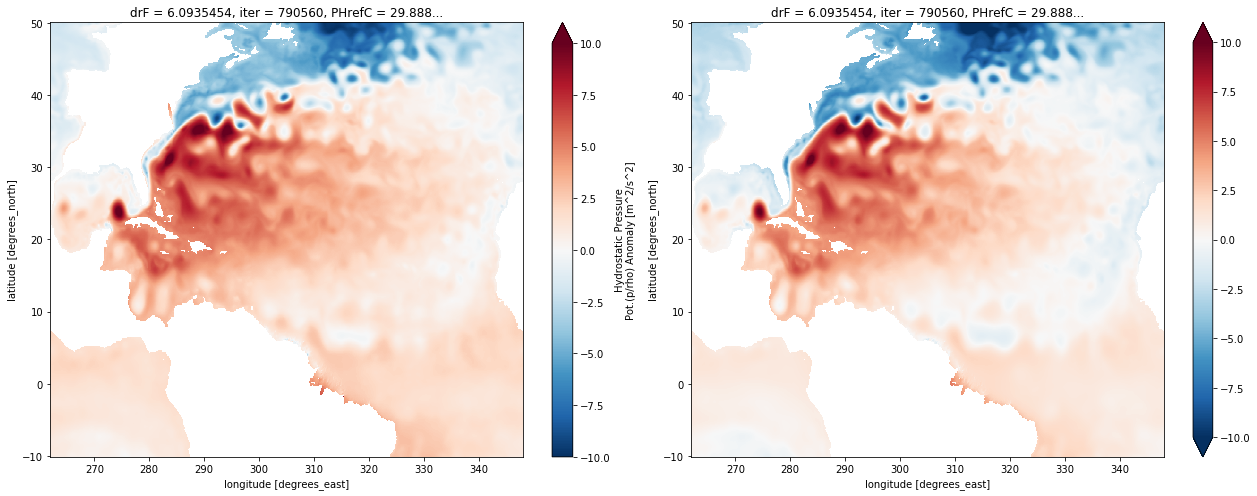

In [117]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
dsocn.PHIHYD.where(dsocn.maskC!=0.)[0,0].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                             ).plot(ax=ax1, vmax=10)
(grav*rho_insitu*(dsocn.ETAN)/rhoConst)[0,0].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                  ).plot(ax=ax2, vmax=10)

In [113]:
(dsocn.PHIHYD.where(dsocn.maskC!=0.)[0,0]-grav*(dsocn.ETAN)[0]).plot()

In [6]:
grid = xgrid(dsocn, periodic=['X'])
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [115]:
rho_insitu = xr.apply_ufunc(jmd95.densjmd95, dsocn.SALT, dsocn.THETA,
                            dsocn.PHIHYD-grav*dsocn.Z, 
                            dask='parallelized', output_dtypes=[float]
                           ).where(dsocn.maskC!=0.)
rho_insitu[0,15].plot(vmin=1035, vmax=1040)

In [7]:
rho2 = xr.apply_ufunc(jmd95.densjmd95, dsocn.SALT, dsocn.THETA, 20e2, 
                      dask='parallelized', output_dtypes=[float]
                     ).where(dsocn.maskC!=0.)
rho2x = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'X'), grid.interp(dsocn.THETA,'X'), 
                       20e2, 
                       dask='parallelized', output_dtypes=[float]
                      ).where(dsocn.maskC!=0.)
rho2y = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'Y',boundary='fill'), 
                       grid.interp(dsocn.THETA,'Y',boundary='fill'), 20e2, 
                       dask='parallelized', output_dtypes=[float]
                      ).where(dsocn.maskC!=0.)

rho2

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<where, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    iter     int64 790560
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskInC  (YC, XC) bool False False False False ... False False False False
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    time     float64 1.581e+08
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9

Since we use potential density at 2000 dbar ($\rho_2$) as the buoyancy coordinate, we probably need to calculate the hydrostatic pressure using $\rho_2$ for consistency, i.e.:
$$\frac{\partial\phi}{\partial z} = -\frac{\rho_2g}{\rho_0}$$

$$\therefore \phi = -\frac{g}{\rho_0}\int^\eta_z \rho_2(z)\ dz \sim \frac{g}{\rho_0}\sum \rho_2 \Delta z.$$

<!-- Actually, **no because the hydrostatic pressure is calculated using insitu density** [(alphaRho)](https://github.com/MITgcm/MITgcm/blob/master/model/src/calc_phi_hyd.F). -->

In [11]:
dz = np.ones_like(rho2)
dz[:,0] = dsocn.ETAN.where(dsocn.maskInC!=0.) + dsocn.drF[0]
drbroad, _ = xr.broadcast(dsocn.drF[1:], dsocn.ETAN[0])
dz[:,1:] = drbroad.data
dz = xr.DataArray(dz, dims=rho2.dims, coords=rho2.coords).where(dsocn.maskC!=0.)
# dz[0,1].plot()

# buoy = -grav * (rho2-rhoConst) * rhoConst**-1
# phi = -grid.interp(grid.cumsum(buoy*dz,'Z',boundary='fill'),
#                                'Z',boundary='fill'
#                               ).where(dsocn.maskC!=0.) * grav*rhoConst**-1
# phi

<xarray.DataArray 'mul-8687b93b6f1afead04e69bf31fc41eda' (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 44, 900, 500), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    iter     int64 790560
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    time     float64 1.581e+08
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    maskInC  (YC, XC) bool False False

In [130]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
grid.interp(-grid.diff(phi*dsocn.hFacC,'Z',boundary='fill',to='outer') / dsocn.drC,
           'Z',boundary='fill').where(dsocn.maskC!=0.)[0,20].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                                               ).plot(ax=ax1, vmax=-10.1, vmin=-10.2)
buoy[0,20].sel(YC=slice(ystart-12**-1,yend+12**-1)
                      ).plot(ax=ax2, vmax=-10.1, vmin=-10.2)

In [44]:
buoy = grid.interp(-grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)*dsocn.hFacC,
                              'Z',boundary='fill',to='outer'
                             ) * dsocn.drC**-1,
                   'Z', boundary='fill'
                  )

# sig_in_z = -grid.diff(buoy.where(dsocn.maskInC!=0.)*dsocn.hFacC,
#                       'Z',boundary='fill',to='outer')**-1 * dsocn.drC
m = dsocn.PHIHYD.where(dsocn.maskC!=0.) - buoy*dsocn.Z
# m = phi - buoy*dsocn.Z
m

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<sub, shape=(2, 46, 900, 1000), dtype=float32, chunksize=(1, 44, 900, 500), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    iter     int64 790560
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskInC  (YC, XC) bool False False False False ... False False False False
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    time     float64 1.581e+08
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.972

In [29]:
fC = xr.apply_ufunc(gsw.f, dsocn.YC, dask='parallelized', output_dtypes=[float])
vg = grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)
               * grid.interp(dsocn.dyG,'X')*dsocn.hFacC*dsocn.drF,'X'
              ) * (dsocn.rAw*dsocn.hFacW*dsocn.drF*fC)**-1
fG = xr.apply_ufunc(gsw.f, dsocn.YG, dask='parallelized', output_dtypes=[float])
ug = -grid.diff(dsocn.PHIHYD.where(dsocn.maskC!=0.)
                * grid.interp(dsocn.dxG,'Y',boundary='fill')*dsocn.hFacC*dsocn.drF,'Y',boundary='fill'
               ) * (dsocn.rAs*dsocn.hFacS*dsocn.drF*fG)**-1
vg

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XG: 1000)>
dask.array<mul, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 499), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
    dxC      (YC, XG) >f4 8995.514 8995.514 8995.514 ... 5487.842 5487.842
    iter     int64 788400
    time     float64 1.577e+08
    maskInW  (YC, XG) bool False False False False ... False False False False
    dyG      (YC, XG) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    rAw      (YC, XG) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    maskW    (Z, YC, XG) bool True True True True ... False False False False
    hFacW    (Z, YC, XG) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.13

In [10]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsocn.drF.sel(Z=slice(None,None))),
                                                            np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
                                                            20)

In [11]:
Dsig = 9.7
nlayers = 51

tmp = np.tanh(np.linspace(-2.,2.75,nlayers))
tmp += np.abs(tmp.min())
tmp *= tmp.max()**-1 * Dsig
# print(tmp)
siglayers = 27.5 + tmp
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))
plt.plot(siglayers)

In [30]:
ugdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                             len(dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                             len(dsocn.XC),len(siglayers))),
                    dims=['nmemb','YG','XC','sig'],
                    coords={'nmemb':range(2),
                            'YG':dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                            'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan
vgdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                             len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                             len(dsocn.XG),len(siglayers))),
                    dims=['nmemb','YC','XG','sig'],
                    coords={'nmemb':range(2),
                            'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                            'XG':dsocn.XG.data,'sig':siglayers}
                   ) * np.nan

for tt in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          vg[tt].where(dsocn.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                 
                                                                     yend+2*12**-1)
                                                           ).chunk({'YC':-1,'XG':xchunk}),
                          (rho2x[tt]-1e3).where(dsocn.maskW!=0.).sel(YC=slice(ystart-12**-1,
                                                                              yend+2*12**-1)
                                                                    ).chunk({'YC':-1,'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          ug[tt].where(dsocn.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                     yend+2*12**-1)
                                                           ).chunk({'YG':-1,'XC':xchunk}),
                          (rho2y[tt]-1e3).where(dsocn.maskS!=0.).sel(YG=slice(ystart-12**-1,
                                                                              yend+2*12**-1)
                                                                    ).chunk({'YG':-1,'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    

        
    ugdz[tt] = tmp2
    vgdz[tt] = tmp1
    
    del tmp1, tmp2

    
ugdz = ugdz.chunk({'nmemb':1,'sig':1})
vgdz = vgdz.chunk({'nmemb':1,'sig':1})

In [13]:
# udz = xr.DataArray(np.ones((len(dsocn.nmemb),
#                             len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
#                             len(dsocn.XG),len(siglayers))),
#                    dims=['nmemb','YC','XG','sig'],
#                    coords={'nmemb':range(2),
#                            'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
#                            'XG':dsocn.XG.data,'sig':siglayers}
#                   ) * np.nan
# vdz = xr.DataArray(np.ones((len(dsocn.nmemb),
#                             len(dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
#                             len(dsocn.XC),len(siglayers))),
#                    dims=['nmemb','YG','XC','sig'],
#                    coords={'nmemb':range(2),
#                            'YG':dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
#                            'XC':dsocn.XC.data,'sig':siglayers}
#                   ) * np.nan
pdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XC),len(siglayers))),
                   dims=['nmemb','YC','XC','sig'],
                   coords={'nmemb':range(2),
                           'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XC':dsocn.XC.data,'sig':siglayers}
                  ) * np.nan
bdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                            len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsocn.XC),len(siglayers))),
                   dims=['nmemb','YC','XC','sig'],
                   coords={'nmemb':range(2),
                           'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XC':dsocn.XC.data,'sig':siglayers}
                  ) * np.nan

for tt in range(2):
#     tmp1 = xr.apply_ufunc(layers_numpy, 
#                           dsocn.UVEL[tt].where(dsocn.maskW!=0.).sel(YC=slice(ystart-12**-1,
#                                                                              yend+2*12**-1)
#                                                                    ),
#                           (rho2x[tt]-1e3).where(dsocn.maskW!=0.).sel(YC=slice(ystart-12**-1,
#                                                                               yend+2*12**-1)
#                                                                     ).chunk({'YC':-1,'XG':xchunk}),
#                           kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                   'mapindex':mapindex,'cellindex':cellindex,
#                                   'drf_finer':drf_finer},
#                           dask='parallelized',
#                           input_core_dims=[['Z'],['Z']], 
#                           output_core_dims=[['sig']],
#         #                            output_core_dims=(['sig2lev']),
#         #                            exclude_dims=set(['Z']),
#                           output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                          ).compute()

#     tmp2 = xr.apply_ufunc(layers_numpy, 
#                           dsocn.VVEL[tt].where(dsocn.maskS!=0.).sel(YG=slice(ystart-12**-1,
#                                                                              yend+2*12**-1)
#                                                                    ),      
#                           (rho2y[tt]-1e3).where(dsocn.maskS!=0.).sel(YG=slice(ystart-12**-1,
#                                                                               yend+2*12**-1)
#                                                                     ).chunk({'YG':-1,'XC':xchunk}),
#                           kwargs={'thetalayers':siglayers,'mapfact':mapfact,
#                                   'mapindex':mapindex,'cellindex':cellindex,
#                                   'drf_finer':drf_finer},
#                           dask='parallelized', 
#                           input_core_dims=[['Z'],['Z']], 
#                           output_core_dims=[['sig']],
#         #                            output_core_dims=(['sig2lev']),
#         #                            exclude_dims=set(['Z']),
#                           output_dtypes=[float,], output_sizes={'sig':siglayers.size}
#                          ).compute()
    
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          (dsocn.PHIHYD[tt]).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                 yend+2*12**-1)),
                          (rho2[tt]-1e3).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp4 = xr.apply_ufunc(layers_numpy, 
                          buoy[tt].chunk({'Z':-1}).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                       yend+2*12**-1)),
                          (rho2[tt]-1e3).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

        
#     udz[tt] = tmp1
#     vdz[tt] = tmp2
    pdz[tt] = tmp3
    bdz[tt] = tmp4
    
    del tmp3, tmp4

    
# udz = udz.chunk({'nmemb':1,'sig':1})
# vdz = vdz.chunk({'nmemb':1,'sig':1})
pdz = pdz.chunk({'nmemb':1,'sig':1})
bdz = bdz.chunk({'nmemb':1,'sig':1})
pdz

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 51)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 51), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.58 27.63 ... 37.17 37.18 37.19 37.2

In [14]:
dzetaF = pdz.load().copy() * np.nan
# dzetaF.coords['time'] = ('time',ds.time.data)

for j in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(rho2[j]).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                    yend+2*12**-1)
                                                                          ).chunk({'XC':xchunk}),
                          (rho2[j]-1e3).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                           ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
            #                            output_core_dims=(['sig2lev']),
            #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
            
    dzetaF[j] = tmp1.data
    
    del tmp1
    
dzetaF = dzetaF.chunk({'nmemb':1,'sig':1})
dzetaF

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 51)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 51), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.58 27.63 ... 37.17 37.18 37.19 37.2

In [17]:
dzetaF.where(dzetaF!=0.)[0,:,:,26].plot(figsize=(11,8))

In [18]:
dssig = dzetaF.to_dataset(name='dzetaF')
dssig.coords['YG'] = ('YG',dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data)
dssig.coords['XG'] = ('XG',dsocn.XG.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)
# dt = np.diff(ds.time)[0]
# dssig.coords['timep1'] = ('timep1',np.append(np.append(ds.time[0].data-.5*dt,
#                                                        .5*(ds.time[1:].data+ds.time[:-1].data)),
#                                              ds.time[-1].data+.5*dt))
dssig

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 723, YG: 723, nmemb: 2, sig: 51, sigp1: 52)
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.58 27.63 ... 37.17 37.18 37.19 37.2
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 27.48 27.52 27.56 27.61 ... 37.18 37.19 37.2 37.2
Data variables:
    dzetaF   (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 723, 1000, 1), meta=np.ndarray>

In [19]:
grids = xgrid(dssig, periodic=['X'], 
              coords={'Z':{'center':'sig','outer':'sigp1'},
                      'Y':{'center':'YC','left':'YG'},
                      'X':{'center':'XC','left':'XG'}}
             )
grids

<xgcm.Grid>
Z Axis (not periodic):
  * center   sig --> outer
  * outer    sigp1 --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [20]:
ug_true = ugdz * grids.interp(dzetaF,'Y',boundary='fill')**-1
vg_true = vgdz * grids.interp(dzetaF,'X')**-1
vg_true

NameError: name 'ugdz' is not defined

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


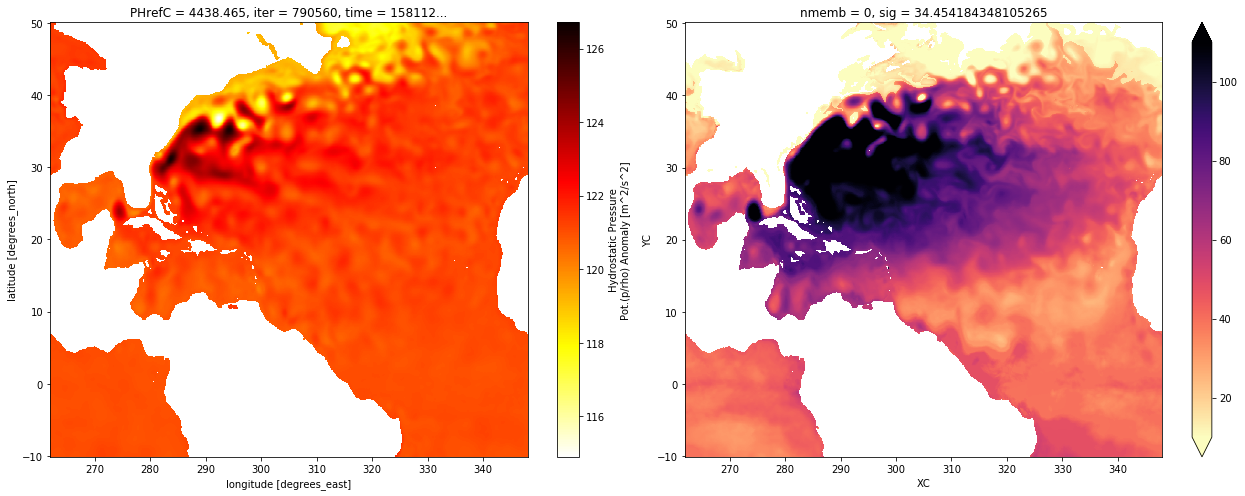

In [23]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
fig.set_tight_layout(True)
(dsocn.PHIHYD).where(dsocn.maskC!=0.)[0,18].sel(YC=slice(ystart-12**-1,yend+12**-1)
                                      ).plot(ax=ax1, cmap='hot_r')
(pdz*dzetaF**-1)[0,:,:,26].plot(ax=ax2, cmap='magma_r', vmin=1e1, vmax=1.1e2)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


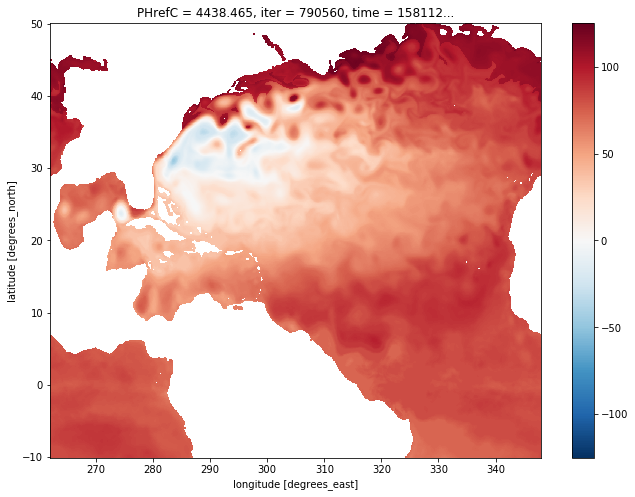

In [24]:
(dsocn.PHIHYD.where(dsocn.maskC!=0.)[0,18]
 - (pdz*dzetaF**-1)[0,:,:,26]).plot(figsize=(11,8))

$$\sigma = \frac{\partial\zeta}{\partial\tilde{b}}$$
where $\tilde{b}=b_2=-g\frac{\rho_2-\rho_0}{\rho_0}$.

$$\zeta = \sum_{\tilde{b}}\Delta\zeta$$

Now, the caveat here is that $\tilde{b}$ is not the same $b$ that satisfies the hydrostatic balance in Cartesian coordinates ($\frac{\partial\phi}{\partial z} = b \neq \tilde{b}$), i.e.
$$\frac{\partial\phi}{\partial x} = \frac{\partial\phi}{\partial\tilde{x}} - \frac{\partial\phi}{\partial\zeta}\frac{\partial\zeta}{\partial\tilde{x}}$$
$$\ \ \ \ \ = \frac{\partial\phi}{\partial\tilde{x}} - b(\tilde{b})\frac{\partial\zeta}{\partial\tilde{x}}$$
$$\ \ \ \ \ \ \ \ \ \ \ \ \ = \frac{\partial\phi}{\partial\tilde{x}} - \frac{\partial}{\partial\tilde{x}}(b\zeta) + \zeta\frac{\partial b}{\partial\tilde{x}}$$
$$\ \ = \frac{\partial m}{\partial\tilde{x}} + \zeta\frac{\partial b}{\partial\tilde{x}}$$

so if we define the Montgomery potential $m \equiv \phi - b\zeta$, the hydrostatic balance in $\tilde{b}$ coordinate becomes:
$$\frac{\partial m}{\partial\tilde{b}} = \frac{\partial}{\partial\tilde{b}}(\phi - b\zeta)$$
$$\ \ \ \ \ \ \ \ = \frac{\partial\phi}{\partial\tilde{b}} - \frac{\partial b}{\partial\tilde{b}}\zeta - b\frac{\partial\zeta}{\partial\tilde{b}}$$
$$\ \ \ \ \ \ \ \ \ \ \ \ \ = \frac{\partial\phi}{\partial\zeta}\frac{\partial\zeta}{\partial\tilde{b}} - \frac{\partial b}{\partial\tilde{b}}\zeta - b\frac{\partial\zeta}{\partial\tilde{b}}$$
$$= -\frac{\partial b}{\partial\tilde{b}}\zeta$$
where $\frac{\partial b}{\partial\tilde{b}}\neq 1$.

In [63]:
sigma = (dzetaF.where(dsocn.maskInC!=0.) 
         * (grav*rhoConst**-1*grids.diff(dssig.sigp1+1e3-rhoConst,'Z',boundary='fill'))**-1          
        )
# sigma = (dzetaF.where(dsocn.maskInC!=0.) 
#          * -grids.diff(bdz*dzetaF**-1,'Z',boundary='fill')**-1
#         )
zeta = -grids.interp(grids.cumsum(dzetaF,'Z',boundary='fill'),
                     'Z',boundary='fill'
                    ).where(dsocn.maskInC!=0.)

b2b = -grav * (dssig.sig+1e3 - rhoConst) * rhoConst**-1
buoyb = bdz*dzetaF**-1
mb = pdz*dzetaF**-1 - buoyb*zeta
# phib = -grids.cumsum(dzetaF*buoyb,'Z',boundary='fill')
# mb = grids.interp(phib,'Z',boundary='fill') - zeta*buoyb
mb

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 51)>
dask.array<sub, shape=(2, 723, 1000, 51), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.58 27.63 ... 37.17 37.18 37.19 37.2
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829
    iter     int64 790560
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    time     float64 1.581e+08

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


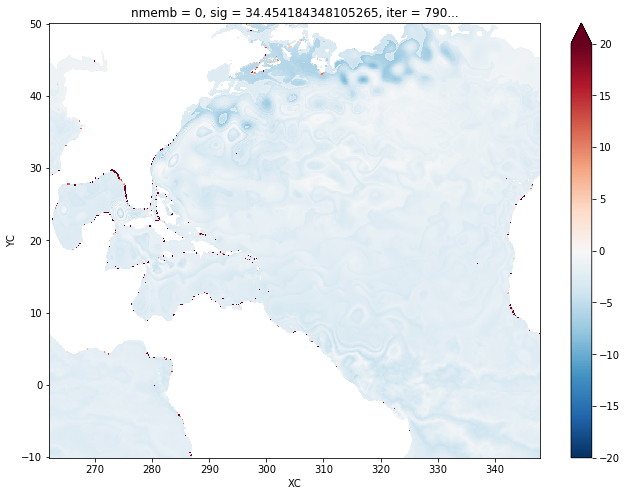

In [64]:
# fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
# fig.set_tight_layout(True)
# m.where(dsocn.maskC!=0.)[0,17].sel(YC=slice(ystart-12**-1,yend+12**-1)
#                                   ).plot(ax=ax1, cmap='Reds')
mb[0,:,:,26].plot(figsize=(11,8), vmax=2e1)

In [65]:
zeta.where(zeta!=0.)[0,:,:,26].plot(cmap='Blues_r', figsize=(11,8))

In [66]:
sigma.where(sigma!=0.)[0,:,:,26].plot(figsize=(11,8), cmap='Reds', vmin=0.)

In [67]:
cos_1 = np.sqrt(1 + (dzetaF/grid.interp(dsocn.dxG,'Y',boundary='fill'))**2 
                + (dzetaF/grid.interp(dsocn.dyG,'X'))**2
               )
cos_1y = np.sqrt(1 + (grids.interp(dzetaF,'Y',boundary='fill')/dsocn.dxG)**2 
                 + (grids.interp(dzetaF,'Y',boundary='fill')
                    / grid.interp(grid.interp(dsocn.dyG,'X'),'Y',boundary='fill')
                   )**2
                )
cos_1x = np.sqrt(1 + (grids.interp(dzetaF,'X')
                      / grid.interp(grid.interp(dsocn.dxG,'Y',boundary='fill'),'X')
                     )**2 
                 + (grids.interp(dzetaF,'X')/dsocn.dyG)**2
                )
cos_1z = np.sqrt(1 + (grids.interp(dzetaF,'Z',boundary='fill')
                      / grid.interp(dsocn.dxG,'Y',boundary='fill')
                     )**2 
                 + (grids.interp(dzetaF,'Z',boundary='fill')
                    / grid.interp(dsocn.dyG,'X')
                   )**2
                )

# print(angle,angley,anglex,anglez)

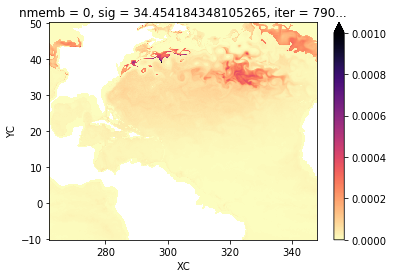

In [68]:
rAb = cos_1 * dsocn.rA.where(dsocn.maskInC!=0.)
rAbz = cos_1z * dsocn.rA.where(dsocn.maskInC!=0.)

(rAb[0,:,:,26]/dsocn.rA.where(dsocn.maskInC!=0.) - 1.).plot(vmin=0., vmax=1e-3, cmap='magma_r')

In [229]:
grids.diff(mb*rAb,'Z',boundary='fill')[0,:,:,48].plot()

In [69]:
mb_b = grids.interp(grids.diff(mb*rAb,'Z',boundary='fill') 
                    * (rAbz*grids.diff(b2b,'Z',boundary='fill'))**-1,
                    'Z', boundary='fill'
                   )
buoyb_b = grids.interp(grids.diff(buoyb*rAb,'Z',boundary='fill') 
                       * (rAbz*grids.diff(b2b,'Z',boundary='fill'))**-1,
                       'Z', boundary='fill'
                      )
# mb_b2 = grids.interp(grids.diff(mb,'Z',boundary='fill') 
#                     / (grids.diff(buoyb,'Z',boundary='fill')),'Z',boundary='fill'
#                    )
mb_b2 = grids.interp(-grids.diff(mb*rAb,'Z',boundary='fill') 
                     * (rAbz*grids.interp(dzetaF,'Z',boundary='fill'))**-1,
                     'Z', boundary='fill'
                    ) * sigma
mb_b2

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 51)>
dask.array<mul, shape=(2, 723, 1000, 51), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.58 27.63 ... 37.17 37.18 37.19 37.2
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829
    iter     int64 790560
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    time     float64 1.581e+08

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


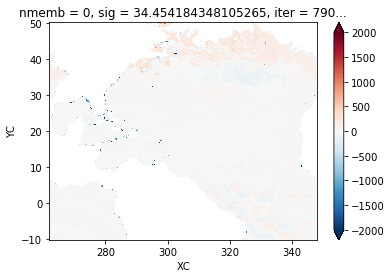

In [70]:
(mb_b - mb_b2)[0,:,:,26].plot(vmax=2e3)

In [71]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
fig.set_tight_layout(True)
(mb_b)[0,:,:,26].plot(ax=ax1, vmax=2e3)
(mb_b2)[0,:,:,26].plot(ax=ax2, vmax=2e3)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*args2)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


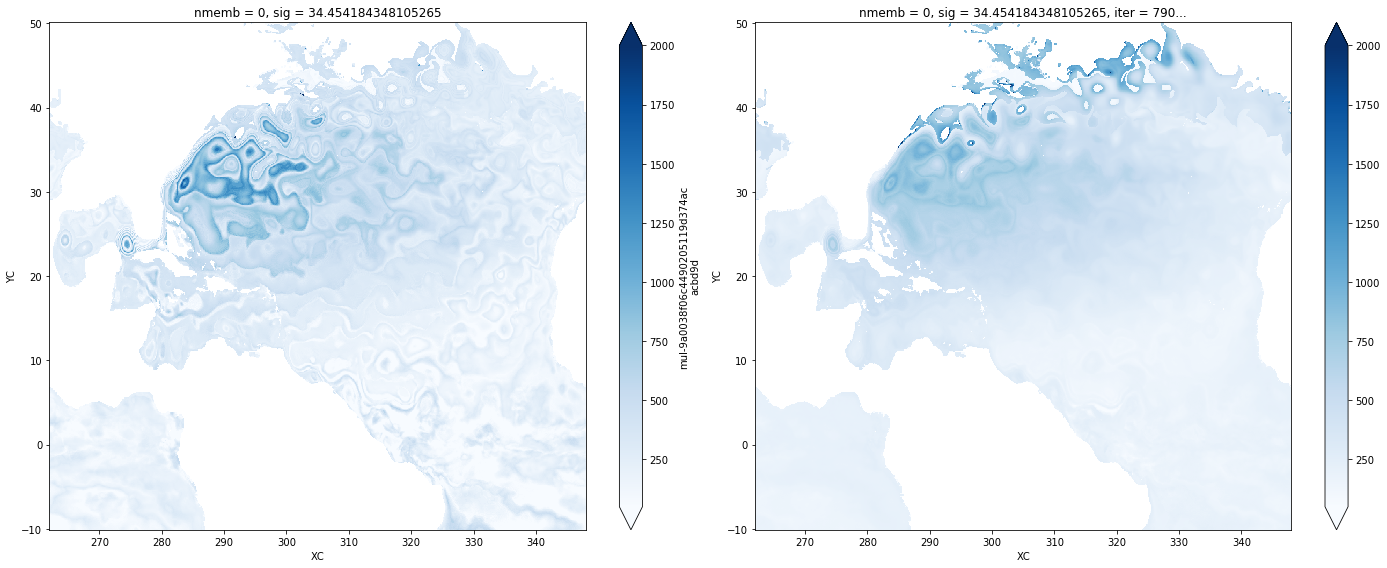

In [72]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
fig.set_tight_layout(True)
(mb_b)[0,:,:,26].plot(ax=ax1, vmin=5e1, vmax=2e3, cmap='Blues')
(-zeta*buoyb_b)[0,:,:,26].plot(ax=ax2, vmin=5e1, vmax=2e3, cmap='Blues')

In [163]:
dxb = grids.interp(np.sqrt(1 + (grids.interp(dzetaF,'Y',boundary='fill')/dsocn.dxG)**2)**-1 * dsocn.dxG,
                   'Y',boundary='fill')
dyb = grids.interp(np.sqrt(1 + (grids.interp(dzetaF,'X')/dsocn.dyG)**2)**-1 * dsocn.dyG,
                   'X')
rAbw = anglex**-1 * dsocn.rAw
rAbs = angley**-1 * dsocn.rAs
vgb = grids.diff(mb * dyb*grids.diff(-grav*(dssig.sigp1+1e3-rho0)*rho0**-1,
                                     'Z',boundary='fill'),'X'
                ) * (rAbw*grids.diff(-grav*(dssig.sigp1+1e3-rho0)*rho0**-1,
                                     'Z',boundary='fill')*fC)**-1
ugb = -grids.diff(mb * dxb*grids.diff(-grav*(dssig.sigp1+1e3-rho0)*rho0**-1,
                                      'Z',boundary='fill'),'Y',boundary='fill'
                 ) * (rAbs*grids.diff(-grav*(dssig.sigp1+1e3-rho0)*rho0**-1,
                                      'Z',boundary='fill')*fG)**-1
vgb

<xarray.DataArray (nmemb: 2, YC: 723, XG: 1000, sig: 43)>
dask.array<mul, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 997, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    iter     int64 788400
    dyG      (YC, XG) >f4 9264.79 9264.79 9264.79 ... 9264.79 9264.79 9264.79
    maskInW  (YC, XG) bool True True True True True ... True True True True True
    time     float64 1.577e+08
    rAw      (YC, XG) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    dxC      (YC, XG) >f4 9419.987 9419.987 9419.987 ... 6139.372 6139.372

In [164]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
fig.set_tight_layout(True)
ug_true[0,:,:,20].plot(ax=ax1, vmax=1)
ugb[0,:,:,20].plot(ax=ax2, vmax=1)